# k-평균 군집화 분석 + 그래프: 타깃 마케팅을 위한 소비자 군집 분석

### 핵심 개념
    비지도 학습: 정답이 없다
    군집화: 데이터를 클러스터로 구성하는 작업
    k-평균 알고리즘: k개의 중심점을 임의로 위치로 잡고 중심점을 기준으로 가까이 있는 데이터를 확인 거리 평균 지점으로 이동
    엘보 방법
        왜곡: 클러스터 중심점 클러스터내의 데이터의 거리 차이의 제곱의 합
        왜곡의 변화를 그래프로 그려보면 엘보 형태로 나타나고 그 지점이 최적의 k 개수
    실루엣 분석 방법
        클러스터 안에서 데이터가 얼마나 조밀하게 모여 있는지 측정하는 도구
        데이터: i
        응집력 a(i): 데이터 i가 해당 클러스터내에서 데이터와 얼마나 가까운가를 나타내는 용어
        분리도 b(i): 가장 가까운 다른 클러스터내의 데이터와 얼마나 떨어져 있는지를 나타내는 지수
        실루엣 계수 s(i): -1 ~ 1 가지고 1에 가까울수록 좋은 군집화

In [1]:
filepath = "./Online Retail.xlsx"
import pandas as pd
import numpy as np

In [2]:
retail_df = pd.read_excel(filepath)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
retail_df['InvoiceNo'].value_counts()

573585     1114
581219      749
581492      731
580729      721
558475      705
           ... 
554023        1
554022        1
554021        1
554020        1
C558901       1
Name: InvoiceNo, Length: 25900, dtype: int64

# 데이터 전처리
    결측치 처리
    이상치 처리
    타입을 통일
    스케일 조정

In [5]:
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]

In [6]:
retail_df.isnull().mean()

InvoiceNo      0.000000
StockCode      0.000000
Description    0.000000
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249423
Country        0.000000
dtype: float64

In [7]:
retail_df.dropna().isnull().mean()

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

In [8]:
retail_df.dropna(inplace=True)

In [9]:
retail_df.shape

(397884, 8)

In [10]:
# 중복 데이터 확인
retail_df[retail_df.duplicated()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


In [11]:
retail_df.duplicated().sum()

5192

In [12]:
# 중복 데이터 제거
retail_df.drop_duplicates(inplace=True)

# 분석용 데이터 추출

In [13]:
# 제품 수, 거래건수, 고객 수, 추가로 국적 확인
data = {'Product' : len(retail_df['StockCode'].unique()), 
 'Transaction' : len(retail_df['InvoiceNo'].unique()), 
 'Customer' : len(retail_df['CustomerID'].unique())}
pd.DataFrame(data, index=['counts'])

,Product,Transaction,Customer
counts,3665,18532,4338


In [14]:
retail_df['Country'].value_counts().head()

United Kingdom    349203
Germany             9025
France              8326
EIRE                7226
Spain               2479
Name: Country, dtype: int64

In [15]:
# 컬럼에 주문 금액 추가 - SaleAmount
retail_df['SaleAmount'] = retail_df['UnitPrice'] * retail_df['Quantity']

In [16]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SaleAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [17]:
# 마지막 주문 후 며칠이 지났는지에 대한 정보
# 1. 고객을 기준으로 데이터 그룹핑 - 분할
# 2. invoice 적용
# Saleamount
# invoiceDate
# 3. count() 결합
# sum
# max
aggregation = {
    'InvoiceNo':'count',
    'SaleAmount':'sum',
    'InvoiceDate':'max'
}
customer_df = retail_df.groupby(['CustomerID']).agg(aggregation)

In [18]:
customer_df.reset_index()

,CustomerID,InvoiceNo,SaleAmount,InvoiceDate
0,12346.0,1,77183.60,2011-01-18 10:01:00
1,12347.0,182,4310.00,2011-12-07 15:52:00
2,12348.0,31,1797.24,2011-09-25 13:13:00
3,12349.0,73,1757.55,2011-11-21 09:51:00
4,12350.0,17,334.40,2011-02-02 16:01:00
...,...,...,...,...
4333,18280.0,10,180.60,2011-03-07 09:52:00
4334,18281.0,7,80.82,2011-06-12 10:53:00
4335,18282.0,12,178.05,2011-12-02 11:43:00
4336,18283.0,721,2045.53,2011-12-06 12:02:00


In [19]:
customer_df.rename(columns={'InvoiceNo':'Freq', 'InvoiceDate':'ElapsedDays'}, inplace=True)

In [20]:
customer_df.head()

,Freq,SaleAmount,ElapsedDays
CustomerID,,,
12346.0,1,77183.60,2011-01-18 10:01:00
12347.0,182,4310.00,2011-12-07 15:52:00
12348.0,31,1797.24,2011-09-25 13:13:00
12349.0,73,1757.55,2011-11-21 09:51:00
12350.0,17,334.40,2011-02-02 16:01:00


In [21]:
import datetime
datetime.date(2022, 1,1)

datetime.date(2022, 1, 1)

In [22]:
customer_df.iloc[0, -1]

Timestamp('2011-01-18 10:01:00')

In [23]:
customer_df['ElapsedDays'] = datetime.datetime(2012, 1, 1) - customer_df['ElapsedDays']

In [24]:
customer_df.head()

,Freq,SaleAmount,ElapsedDays
CustomerID,,,
12346.0,1,77183.60,347 days 13:59:00
12347.0,182,4310.00,24 days 08:08:00
12348.0,31,1797.24,97 days 10:47:00
12349.0,73,1757.55,40 days 14:09:00
12350.0,17,334.40,332 days 07:59:00


In [25]:
customer_df.iloc[0, -1].days

347

In [26]:
customer_df['ElapsedDays'] = customer_df['ElapsedDays'].apply(lambda x:x.days)

In [27]:
# boxplot을 이용해서 데이터 분포를 확인
import matplotlib.pyplot as plt
import seaborn as sns

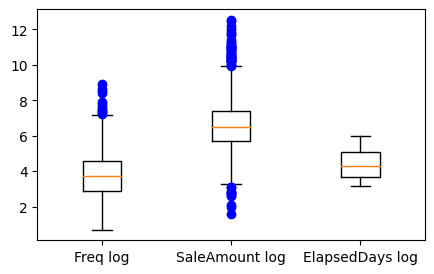

In [31]:
plt.figure(figsize=(5,3))
plt.boxplot( [customer_df['Freq_log'], customer_df['SaleAmount_log'], customer_df['ElapsedDays_log']],
            sym='bo')
plt.xticks([1,2,3],['Freq log','SaleAmount log','ElapsedDays log'])
plt.show()

In [30]:
customer_df['Freq_log'] = np.log1p(customer_df['Freq'])
customer_df['SaleAmount_log'] = np.log1p(customer_df['SaleAmount'])
customer_df['ElapsedDays_log'] = np.log1p(customer_df['ElapsedDays'])

In [32]:
# 분석 모델 구축 Kmeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler

In [33]:
X_feature = customer_df.iloc[:, -3:]

In [34]:
X_feature_scaled = StandardScaler().fit_transform(X_feature)

In [35]:
# 최적의 k의 개수를 찾는 방법
# 1. 엘보우 방법
result = []
for i in range(1, 10):
    kmeans_i = KMeans(n_clusters=i, random_state=0, n_init=10)
    kmeans_i.fit(X_feature_scaled)
    result.append(kmeans_i.inertia_)


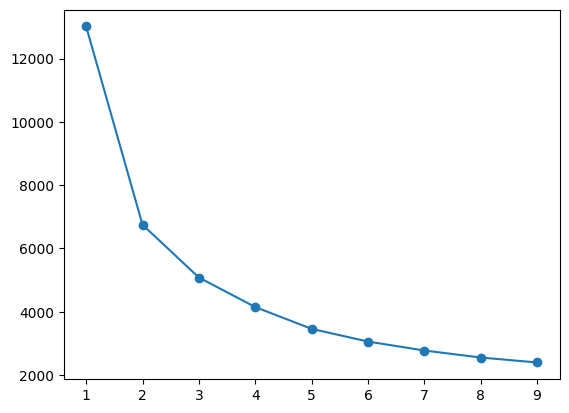

In [36]:
plt.plot(range(1,10), result, marker = 'o')

In [37]:
# 클러스터의 개수는 2나 3개 적당
# k = 3으로 해서 모델을 재구축
kmeans = KMeans(n_clusters=3, random_state=0, n_init = 10)
Y_labels = kmeans.fit_predict(X_feature_scaled)

In [38]:
Y_labels

array([1, 0, 2, ..., 2, 0, 0])

In [39]:
customer_df.head()

,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log
CustomerID,,,,,,
12346.0,1,77183.60,347,0.693147,11.253955,5.852202
12347.0,182,4310.00,24,5.209486,8.368925,3.218876
12348.0,31,1797.24,97,3.465736,7.494564,4.584967
12349.0,73,1757.55,40,4.304065,7.472245,3.713572
12350.0,17,334.40,332,2.890372,5.815324,5.808142


In [40]:
# 실루엣 계수를 구하고 각 클러스터의 비중을  bar chart로 시각화 - 함수정의
from matplotlib import cm
def silhouetteViz(n_cluser, X_feature):
    kmeans = KMeans(n_clusters = n_cluser, random_state=0, n_init=10)
    Y_labels = kmeans.fit_predict(X_feature)
    silhouette_values =  silhouette_samples(X_feature,Y_labels)
    
    y_ax_lower, y_ax_upper = 0,0
    y_ticks = []
    
    for c in range(n_cluser):
        c_silhouettes =  silhouette_values[Y_labels == c]
        c_silhouettes.sort()
        y_ax_upper += len(c_silhouettes)
        color = cm.jet(float(c) / n_cluser)
        plt.barh( range(y_ax_lower, y_ax_upper), c_silhouettes, height=1.0, edgecolor='none',color=color)
        y_ticks.append( (y_ax_lower +  y_ax_upper) /2 )
        y_ax_lower += len(c_silhouettes)
        
        silhouette_avg =  np.mean(silhouette_values)
        plt.axvline(silhouette_avg, color = 'red', linestyle = '--')
        plt.title(f"Number of Cluser {n_cluser}  silhouette score {round(silhouette_avg,3)}")
    plt.show()    

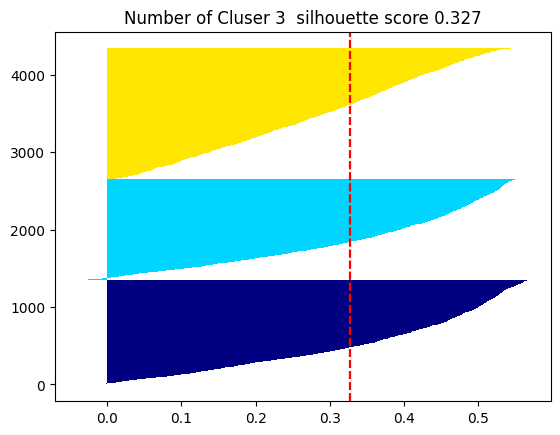

In [41]:
silhouetteViz(3, X_feature_scaled)

In [42]:
result = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters= i, random_state=0, n_init=10)
    Y_labels = kmeans.fit_predict(X_feature)
    silhouette_values = silhouette_samples(X_feature, Y_labels)
    silhouette_avg = np.mean(silhouette_values)
    result.append(silhouette_avg)

In [43]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
Y_labels = kmeans.fit_predict(X_feature)
customer_df['ClusterLabel'] = Y_labels
customer_df.head()

,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log,ClusterLabel
CustomerID,,,,,,,
12346.0,1,77183.60,347,0.693147,11.253955,5.852202,1
12347.0,182,4310.00,24,5.209486,8.368925,3.218876,1
12348.0,31,1797.24,97,3.465736,7.494564,4.584967,1
12349.0,73,1757.55,40,4.304065,7.472245,3.713572,1
12350.0,17,334.40,332,2.890372,5.815324,5.808142,0


In [44]:
grouped = customer_df.groupby(['ClusterLabel'])
grouped['CustomerID'].count()

KeyError: 'Column not found: CustomerID'